In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from analysis.measure import ConfusionMatrix, ROC

#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
iris_data = pd.read_csv('data-sets/iris.csv')
housing_data = pd.read_csv('data-sets/housing.csv')

#randomize data with given seed
iris_data = iris_data.reindex(np.random.RandomState(seed=42).permutation(iris_data.index))
housing_data = housing_data.reindex(np.random.RandomState(seed=42).permutation(housing_data.index))

## Test K Means Clustering with Iris Data

# Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 73 to 102
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
73,74,6.1,2.8,4.7,1.2,Iris-versicolor
18,19,5.7,3.8,1.7,0.3,Iris-setosa
118,119,7.7,2.6,6.9,2.3,Iris-virginica
78,79,6.0,2.9,4.5,1.5,Iris-versicolor
76,77,6.8,2.8,4.8,1.4,Iris-versicolor


## Set up Data

In [4]:
x_train, y_train = iris_data.drop(['Species'], axis=1)[:110], iris_data['Species'][:110]
x_test, y_test = iris_data.drop(['Species'], axis=1)[110:], iris_data['Species'][110:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)

## Feature Scaling

Min Max Scaling

In [5]:
min_max_scaler = MinMaxScaler((0, 1))
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train)
x_train_min_max_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.500000,0.333333,0.627119,0.458333
1,0.388889,0.750000,0.118644,0.083333
2,0.944444,0.250000,1.000000,0.916667
3,0.472222,0.375000,0.593220,0.583333
4,0.694444,0.333333,0.644068,0.541667


## PCA with Dimension 3

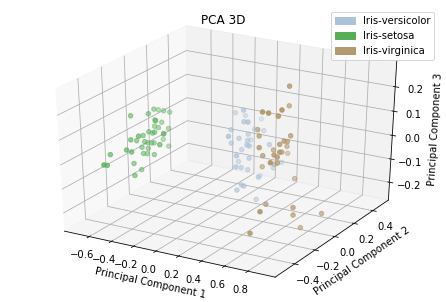

In [6]:
pca3 = PCA(3)
iris_pca_data3 = pca3.fit_transform(x_train_min_max_scaled)
pca3.plot("PCA 3D", y_train.values)

## Transform Test Dimensions

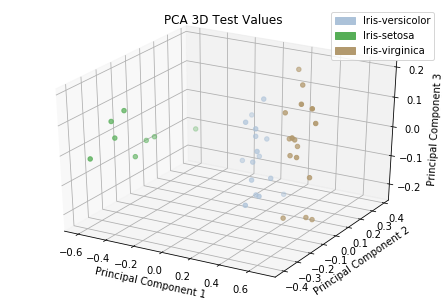

In [7]:
x_test_scaled = min_max_scaler.transform(x_test)
pca3.fit(x_train_min_max_scaled)
iris_pca_test_data = pca3.transform(x_test_scaled)
pca3.plot("PCA 3D Test Values", y_test.values)

## K Means Clustering

In [8]:
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
colors_list = list(colors._colors_full_map.values())

class KMC:
    def __init__(self, k, random_state = 0, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.labels = None
        self.random_state = random_state
        
    def initialize_centroids(self, train_data):
        if (self.k > len(train_data)):
            print("k cannot be greater than size of data")
            return
        centroids = train_data.sample(self.k, random_state=self.random_state).to_numpy()
        return centroids
        
    def calculate_centroids(self):
        self.train_data['cluster'] = self.cluster_belongings
        new_centroids = []
        for i in range(self.k):
            cluster_k_data = self.train_data[self.train_data['cluster']==i]
            cluster_k_data = cluster_k_data.drop(['cluster'], axis=1)
            new_centroid = []
            for column in cluster_k_data.columns:
                new_centroid.append(np.mean(cluster_k_data[column]))
            new_centroids.append(new_centroid)
        return new_centroids
    
    def assign_clusters(self):
        old_centroids = self.centroids
        total_error = 0
        for i in range(len(self.train_data)):
            sample = self.train_data.iloc[i]
            #calculate closest cluster and its distance
            cluster, distance = self.closest_cluster(old_centroids, sample)
            total_error += distance
            self.cluster_belongings[i] = cluster
        return self.cluster_belongings, total_error
    
    def euclidean_distance(self, point1, point2):
        distance = 0
        for i in range(len(point1)):
            distance += ((point2[i] - point1[i])**2)
        return math.sqrt(distance)
    
    def closest_cluster(self, centroids, sample):
        closest_c = 0
        shortest_distance = self.euclidean_distance(centroids[0], sample)
        for i in range(1, self.k):
            dist = self.euclidean_distance(centroids[i], sample)
            if (dist < shortest_distance):
                closest_c = i
                shortest_distance = dist
        return closest_c, shortest_distance
    
    def fit(self, train_data):
        if ('cluster' in train_data.columns):
            #drop cluster when rerunning
            train_data = train_data.drop(['cluster'], axis=1) 
        self.train_data = train_data
        self.n_features = len(self.train_data.columns)
        #initialize centroids
        self.centroids = self.initialize_centroids(train_data)
        #set all cluster belongings to cluster 0
        self.cluster_belongings = [0 for i in range(len(train_data))]
        for iteration in range(self.max_iter):
            old_centroids = self.centroids
            #assign clusters
            self.cluster_belongings, total_error = self.assign_clusters()
            #recalculate centroids
            self.centroids = self.calculate_centroids()
            if np.all(self.centroids == old_centroids):
                self.assign_clusters()
                return self.cluster_belongings, self.centroids, total_error
        return "error, reached max iterations"
    
    def set_cluster_labels(self, labels):
        if (len(labels) != len(self.centroids)):
            return "Must be the same size!"
        self.labels = labels
            
    def predict(self, results, test_data):
        self.test_data = test_data
        self.data_predictions = []
        for sample in results:
            cluster, distance = self.closest_cluster(self.centroids, sample)
            self.data_predictions.append(cluster)
        return self.data_predictions, self.centroids
    
    def plot_fit(self, roationAngle = None):
        fig=plt.figure()
        if (self.n_features > 3):
            return "cannot plot more than 3 dimensions"
        if (self.n_features == 3):
            ax = Axes3D(fig)
            ax.set_xlabel(self.train_data.columns[0])
            ax.set_ylabel(self.train_data.columns[1])
            ax.set_zlabel(self.train_data.columns[2])
            if (roationAngle != None):
                ax.view_init(azim=roationAngle)
        elif (self.n_features == 2):
            ax=fig.add_axes([0,0,1,1])
            ax.set_xlabel(self.train_data.columns[0])
            ax.set_ylabel(self.train_data.columns[1])
            
        self.train_data['cluster'] = self.cluster_belongings

        for i in range(len(self.centroids)):
            cluster_k_data = self.train_data[self.train_data['cluster']==i]
            ax.scatter(cluster_k_data[cluster_k_data.columns[0]], cluster_k_data[cluster_k_data.columns[1]], cluster_k_data[cluster_k_data.columns[2]], c=colors_list[i])

        ax.set_title("Train Results for Iris data")
        if (self.labels != None):
            plt.legend(handles=[mpatches.Patch(color=colors_list[i], label=self.labels[i]) for i in range(len(self.labels))])
        plt.show()
        
    def plot_predictions(self, roationAngle = None):
        fig=plt.figure()
        if (self.n_features > 3):
            return "cannot plot more than 3 dimensions"
        if (self.n_features == 3):
            ax = Axes3D(fig)
            ax.set_xlabel(self.test_data.columns[0])
            ax.set_ylabel(self.test_data.columns[1])
            ax.set_zlabel(self.test_data.columns[2])
            if (roationAngle != None):
                ax.view_init(azim=roationAngle)
        elif (self.n_features == 2):
            ax=fig.add_axes([0,0,1,1])
            ax.set_xlabel(self.test_data.columns[0])
            ax.set_ylabel(self.test_data.columns[1])

        self.test_data['cluster'] = self.data_predictions
        for i in range(len(self.centroids)):
            cluster_k_data = self.test_data[self.test_data['cluster']==i]
            ax.scatter(cluster_k_data[cluster_k_data.columns[0]], cluster_k_data[cluster_k_data.columns[1]], cluster_k_data[cluster_k_data.columns[2]], c=colors_list[i])

        ax.set_title("Test Results for Iris data")
        if (self.labels != None):
            plt.legend(handles=[mpatches.Patch(color=colors_list[i], label=self.labels[i]) for i in range(len(self.labels))])
        plt.show()

    def screePlot(self, train_data, max_clusters= 10):
        errors_per_number_of_cluster = []
        for i in range(1, max_clusters):
            kmc_i = KMC(i)
            centroid_prediction, centroids, total_error = kmc_i.fit(train_data)
            errors_per_number_of_cluster.append(total_error)
        plt.plot([i for i in range(1, max_clusters)], errors_per_number_of_cluster)
        plt.show()
        
    def get_test_prediction_labels(self):
        if (self.labels == None):
            return "no labels to assign"
        test_result_labels = []
        for cluster in self.data_predictions:
            test_result_labels.append(self.labels[cluster])
        return test_result_labels
        
    def set_k(self, k):
        self.k = k

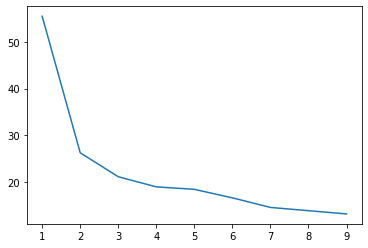

In [9]:
kmc = KMC(3)
kmc.screePlot(iris_pca_data3)

In [10]:
kmc.set_k(4)
train_centroid_prediction, train_centroids, total_Error = kmc.fit(iris_pca_data3)

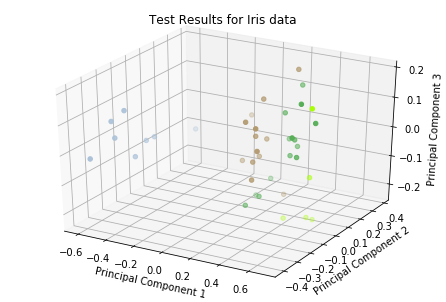

In [11]:
centroid_prediction, centroids = kmc.predict(iris_pca_test_data.values, iris_pca_test_data)
kmc.plot_predictions()

## Iris Data K Means Clustering with k=3

## Train Model and Analyze Centroids assigned

In [12]:
kmc.set_k(3)
train_centroid_prediction, train_centroids, total_Error = kmc.fit(iris_pca_data3)
train_centroids

[[-0.5794941682867414, -0.06068386680273553, -0.0011727302968037386],
 [0.5327554760401894, -0.08615097047416531, 0.010772676643415954],
 [0.1612361853311347, 0.17656741696202657, -0.010580052709287946]]

## Visualize Train Data Clusters

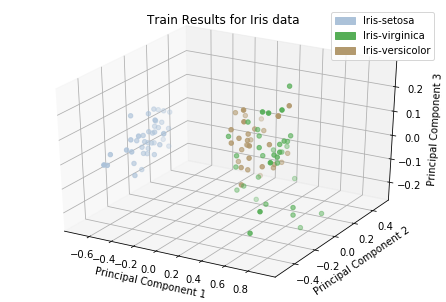

In [13]:
kmc.set_cluster_labels(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'])
kmc.plot_fit()

## Predict Test Results

In [14]:
centroid_prediction_k3, centroids_k3 = kmc.predict(iris_pca_test_data.values, iris_pca_test_data)

## Predict Test labels

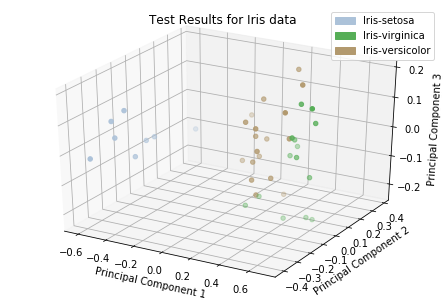

In [15]:
kmc.plot_predictions()

In [16]:
prediction_labels = kmc.get_test_prediction_labels()

# Analyze Results

## Confusion Matrix

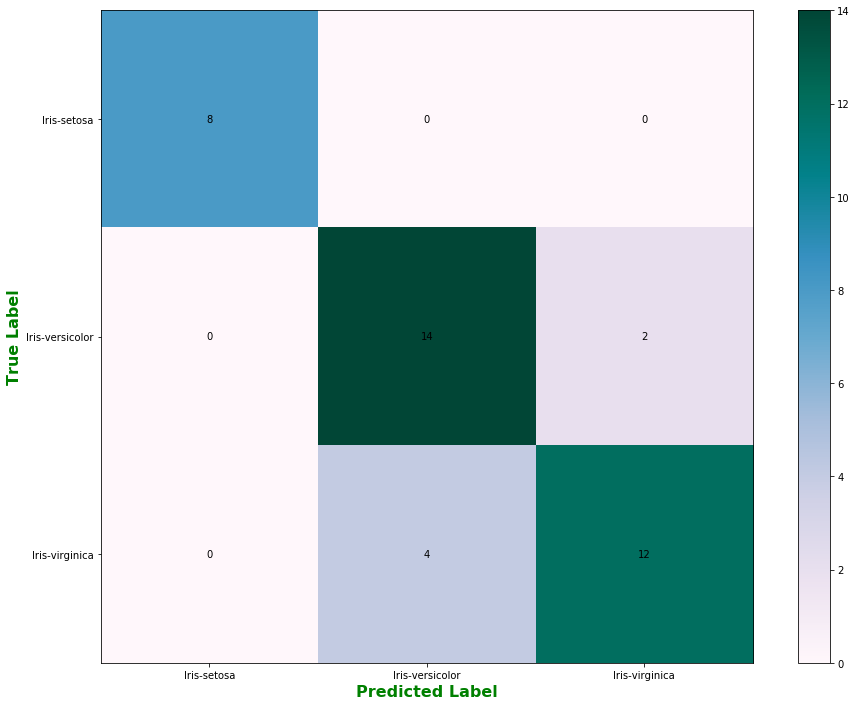

In [17]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(prediction_labels, y_test.values)
confusion_matrix.plot()

# Compare with SKLearn

In [18]:
from sklearn.cluster import KMeans
kmeans_sklearn = KMeans(n_clusters=3, random_state=0).fit(iris_pca_data3)
sk_predictions = kmeans_sklearn.predict(iris_pca_test_data)
sk_predictions

array([2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0,
       1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0])

In [19]:
kmeans_sklearn.cluster_centers_

array([[ 0.62629039, -0.10968335,  0.01571672,  0.        ],
       [-0.57949417, -0.06068387, -0.00117273,  0.        ],
       [ 0.20189524,  0.123042  , -0.00799217,  0.        ]])

In [20]:
sk_pred_centroid_labels = ['Iris-virginica', 'Iris-setosa', 'Iris-versicolor']
sk_learn_test_result_labels = []
for cluster in sk_predictions:
    sk_learn_test_result_labels.append(sk_pred_centroid_labels[cluster])

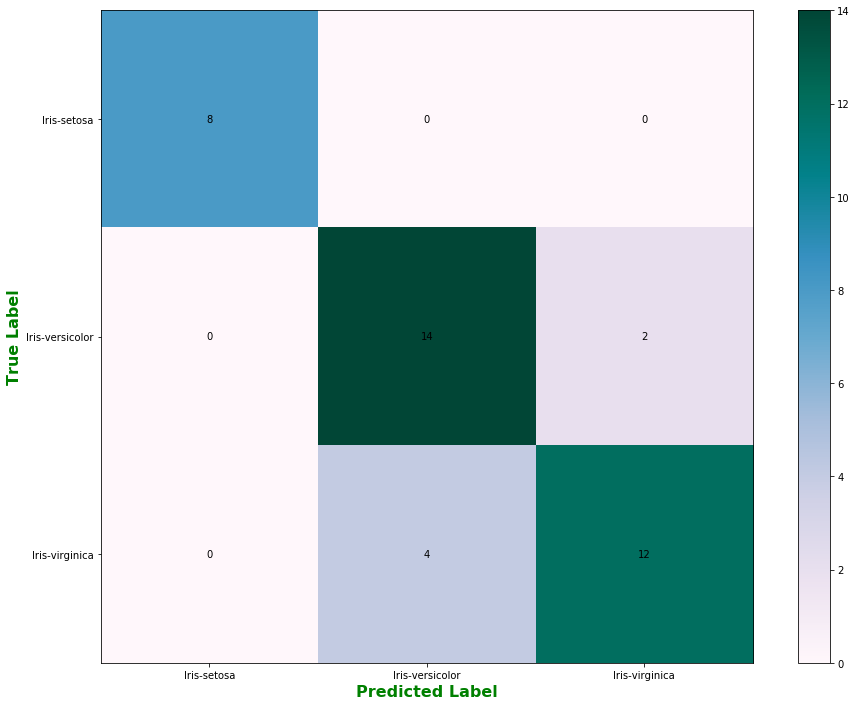

In [21]:
sk_confusion_matrix = ConfusionMatrix()
sk_confusion_matrix.fit(sk_learn_test_result_labels, y_test.values)
sk_confusion_matrix.plot()

# Test K Means Clustering with California Housing Data

# Analyze the Data

In [22]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 20046 to 15795
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [23]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


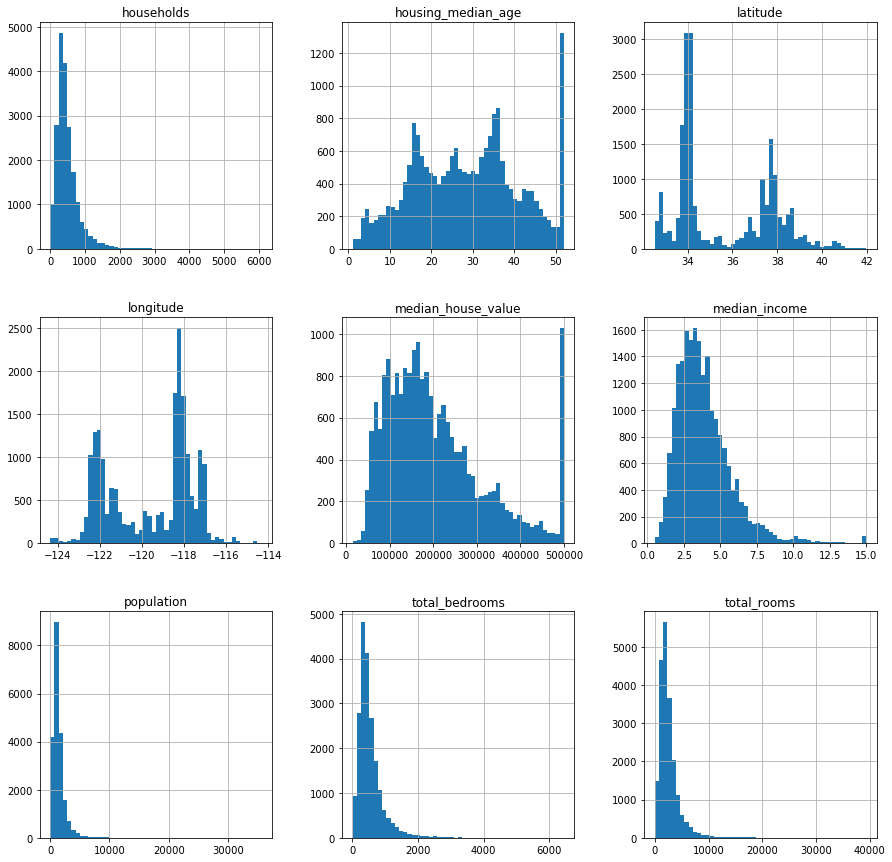

In [24]:
housing_data.hist(bins=50, figsize=(15,15))
plt.show()

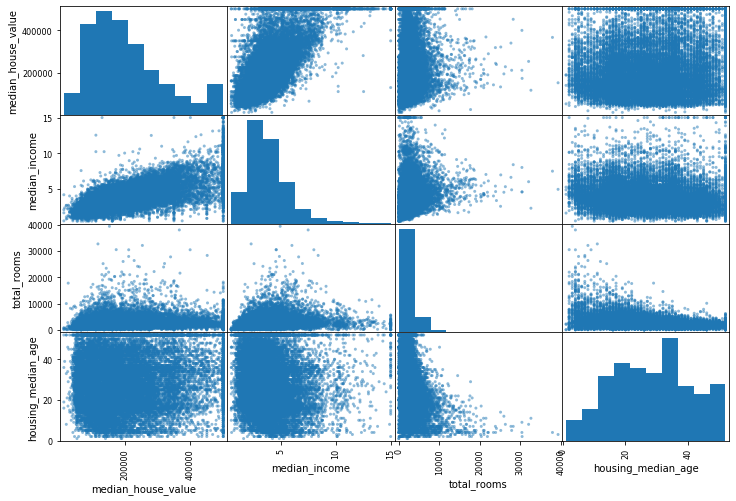

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_data[attributes], figsize=(12, 8))

housing_data["rooms_per_household"] = housing_data["total_rooms"]/housing_data["households"]

In [26]:
corr_matrix = housing_data.corr() 
corr_matrix["median_house_value"].sort_values(ascending=False) 

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
population            -0.024650
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

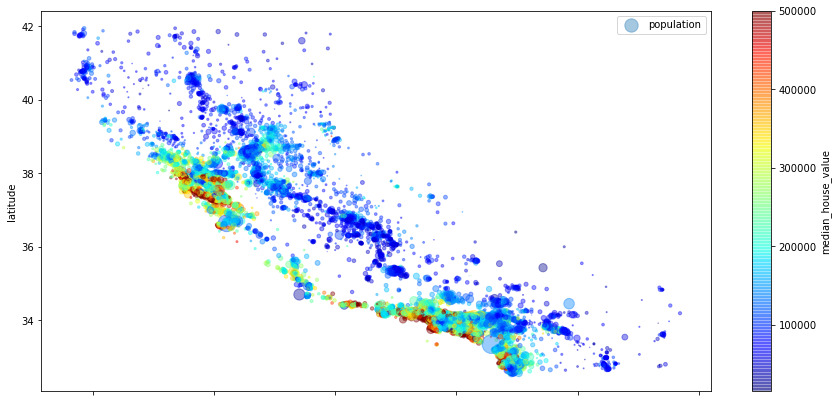

In [27]:
housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing_data["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7))
plt.legend()

In [28]:
housing_data = housing_data.drop(['households', 'total_bedrooms', 'population'], axis=1)

## Handling text and categorical attributes

In [29]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
labelEncoder = LabelEncoder() 
housing_cat = housing_data["ocean_proximity"] 
housing_cat_encoded = labelEncoder.fit_transform(housing_cat) 

oneHotEncoder = OneHotEncoder()
housing_cat_1hot = oneHotEncoder.fit_transform(housing_cat_encoded.reshape(-1,1)) 
housing_cat_array = housing_cat_1hot.toarray()
housing_cat_df = pd.DataFrame(housing_cat_array, columns = labelEncoder.classes_)
for columnClass in labelEncoder.classes_:
    housing_data[columnClass] = housing_cat_df[columnClass]
housing_data = housing_data.drop(['ocean_proximity'], axis=1)

## Set up Data

In [30]:
seventy_five_percentile = int(len(housing_data)*0.75)
x_train, y_train = housing_data.drop(['median_house_value'], axis=1)[:seventy_five_percentile], housing_data['median_house_value'][:seventy_five_percentile]
x_test, y_test = housing_data.drop(['median_house_value'], axis=1)[seventy_five_percentile:], housing_data['median_house_value'][seventy_five_percentile:]
x_train_coordinates, x_test_coordinates = x_train[['latitude', 'longitude']], x_test[['latitude', 'longitude']]
x_train = x_train.drop(['latitude', 'longitude'], axis=1)
x_test = x_test.drop(['latitude', 'longitude'], axis=1)

# Feature Scaling

In [31]:
x_train.head()

,housing_median_age,total_rooms,median_income,rooms_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20046,25.0,1505.0,1.6812,4.192201,0.0,0.0,0.0,0.0,1.0
3024,30.0,2943.0,2.5313,5.039384,0.0,0.0,0.0,0.0,1.0
15663,52.0,3830.0,3.4801,3.977155,0.0,1.0,0.0,0.0,0.0
20484,17.0,3051.0,5.7376,6.163636,0.0,1.0,0.0,0.0,0.0
9814,34.0,2351.0,3.7250,5.492991,0.0,1.0,0.0,0.0,0.0


In [32]:
standard_scaler = StandardScaler()
x_train_standard_scaled = standard_scaler.fit_transform(x_train)
x_train_standard_scaled.head()

,housing_median_age,total_rooms,median_income,rooms_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20046,-0.290806,-0.513620,-1.155641,-0.538499,-0.88999,-0.685526,-0.016077,-0.352628,2.616471
3024,0.105825,0.146215,-0.706809,-0.164886,-0.88999,-0.685526,-0.016077,-0.352628,2.616471
15663,1.851000,0.553220,-0.205867,-0.633336,-0.88999,1.458734,-0.016077,-0.352628,-0.382194
20484,-0.925415,0.195771,0.986036,0.330917,-0.88999,1.458734,-0.016077,-0.352628,-0.382194
9814,0.423129,-0.125428,-0.076566,0.035158,-0.88999,1.458734,-0.016077,-0.352628,-0.382194


# Principal Component Analysis

# PCA 3D

In [33]:
pca = PCA(3)
pca_data_3d = pca.fit_transform(x_train_standard_scaled)
pca_data_3d

,Principal Component 1,Principal Component 2,Principal Component 3
0,0.722786,-0.817618,-2.169324
1,0.204761,-0.608145,-2.163128
2,0.384547,-1.822457,0.867742
3,-1.681695,-0.962699,0.959154
4,-0.296180,-1.533330,0.918705
...,...,...,...
15475,2.262859,0.534968,0.334824
15476,0.097179,1.439406,0.295703
15477,0.602608,1.228189,0.370854
15478,2.209605,0.557711,0.338182


## Scale and Transform Test Dimensions

In [34]:
x_test_scaled = standard_scaler.transform(x_test)
pca_3d_test_data = pca.transform(x_test_scaled)

# K Means Clustering

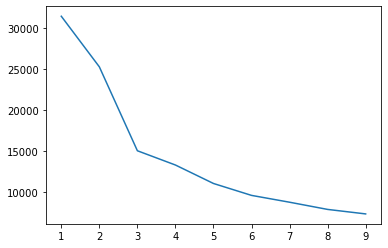

In [35]:
kmc = KMC(3)
kmc.screePlot(pca_data_3d)

In [36]:
kmc = KMC(3)
kmc.fit(pca_data_3d)
centroid_prediction, centroids = kmc.predict(pca_3d_test_data.values)
x_test_coordinates['cluster'] = centroid_prediction

TypeError: predict() missing 1 required positional argument: 'test_data'

In [ ]:
colors_list = list(colors._colors_full_map.values())

for i in range(len(centroids)):
    cluster_k_data = x_test_coordinates[x_test_coordinates['cluster']==i]
    plt.scatter(cluster_k_data['longitude'], cluster_k_data['latitude'], c=colors_list[i])
    plt.show()